<a href="https://colab.research.google.com/github/letsGoBharat/Speech-and-Speaker-Recognition/blob/master/Feature_Extraction/feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###lab1_proto

In [0]:
import numpy as np
import math
import scipy.signal as sig
import scipy.fftpack as fftp
from sklearn.mixture import GaussianMixture
from scipy.spatial import distance

# DT2119, Lab 1 Feature Extraction

# Function given by the exercise ----------------------------------

def mspec(samples, winlen = 400, winshift = 200, preempcoeff=0.97, nfft=512, samplingrate=20000):
    """Computes Mel Filterbank features.

    Args:
        samples: array of speech samples with shape (N,)
        winlen: lenght of the analysis window
        winshift: number of samples to shift the analysis window at every time step
        preempcoeff: pre-emphasis coefficient
        nfft: length of the Fast Fourier Transform (power of 2, >= winlen)
        samplingrate: sampling rate of the original signal

    Returns:
        N x nfilters array with mel filterbank features (see trfbank for nfilters)
    """
    frames = enframe(samples, winlen, winshift, samplingrate)
    preemph = preemp(frames, preempcoeff)
    windowed = windowing(preemph)
    spec = powerSpectrum(windowed, nfft)
    return logMelSpectrum(spec, samplingrate, False)

def mfcc(samples, winlen = 400, winshift = 200, preempcoeff=0.97, nfft=512, nceps=13, samplingrate=20000, liftercoeff=22):
    """Computes Mel Frequency Cepstrum Coefficients.

    Args:
        samples: array of speech samples with shape (N,)
        winlen: lenght of the analysis window
        winshift: number of samples to shift the analysis window at every time step
        preempcoeff: pre-emphasis coefficient
        nfft: length of the Fast Fourier Transform (power of 2, >= winlen)
        nceps: number of cepstrum coefficients to compute
        samplingrate: sampling rate of the original signal
        liftercoeff: liftering coefficient used to equalise scale of MFCCs

    Returns:
        N x nceps array with lifetered MFCC coefficients
    """
    mspecs = mspec(samples, winlen, winshift, preempcoeff, nfft, samplingrate)
    ceps = cepstrum(mspecs, nceps)
    return lifter(ceps, liftercoeff)

# Functions to be implemented ----------------------------------

def enframe(samples, winlen, winshift, sampling_rate):
    """
    Slices the input samples into overlapping windows.

    Args:
        winlen: window length in samples.
        winshift: shift of consecutive windows in samples
    Returns:
        numpy array [N x winlen], where N is the number of windows that fit
        in the input signal
    """
    # Comment added by us vv
    ''' The sample rate is 20kHz or 20 000 samples per second
    If we want to know how many samples fit in 2 ms (window length), 
    we calculate 20 000 * 0.02 which is equal to 400 samples per window.

    N is going to be the number of "windows" overlapping that we can fit using
    all the samples, which is given by round((samples.size - winshift) / step).
    This is because each time we add a new window to the array, we use 
    #winshift new samples, except for the first one where we use #winlen new samples.
    '''
    # Comment added by us ^^

    step = winlen - winshift
    N = math.floor((samples.size - winshift) / step)

    frames = np.zeros((N, winlen))

    for i in range(N):
      frames[i] = samples[step*i : step*i + winlen]
    
    return frames
    
def preemp(input, p=0.97):
    """
    Pre-emphasis filter.

    Args:
        input: array of speech frames [N x M] where N is the number of frames and
               M the samples per frame
        p: preemhasis factor (defaults to the value specified in the exercise)

    Output:
        output: array of pre-emphasised speech samples
    Note (you can use the function lfilter from scipy.signal)
    """
    # Comment added by us vv
    ''' a_0 = 1, b_0 = 1 and b_1 = -p
    The rest of b_i and a_j are assumed to be 0
    '''
    # Comment added by us ^^

    return sig.lfilter([1, -p], [1], input)

def windowing(input):
    """
    Applies hamming window to the input frames.

    Args:
        input: array of speech samples [N x M] where N is the number of frames and
               M the samples per frame
    Output:
        array of windoed speech samples [N x M]
    Note (you can use the function hamming from scipy.signal, include the sym=0 option
    if you want to get the same results as in the example)
    """
    # Comment added by us vv
    ''' sym is False to generate periodic window and non-symmetric
    '''
    # Comment added by us ^^

    M = input.shape[1]
    window = sig.hamming(M, False)
    return (input * window)

def powerSpectrum(input, nfft):
    """
    Calculates the power spectrum of the input signal, that is the square of the modulus of the FFT

    Args:
        input: array of speech samples [N x M] where N is the number of frames and
               M the samples per frame
        nfft: length of the FFT
    Output:
        array of power spectra [N x nfft]
    Note: you can use the function fft from scipy.fftpack
    """

    return np.square(np.absolute(fftp.fft(input, nfft)))

def logMelSpectrum(input, samplingrate, plot_fb=False):
    """
    Calculates the log output of a Mel filterbank when the input is the power spectrum

    Args:
        input: array of power spectrum coefficients [N x nfft] where N is the number of frames and
               nfft the length of each spectrum
        samplingrate: sampling rate of the original signal (used to calculate the filterbank shapes)
    Output:
        array of Mel filterbank log outputs [N x nmelfilters] where nmelfilters is the number
        of filters in the filterbank
    Note: use the trfbank function provided in lab1_tools.py to calculate the filterbank shapes and
          nmelfilters
    """
    # Comment added by us vv
    '''
    Plot of filter_bank on liner frequency scale included
    '''
    # Comment added by us ^^

    nfft = input.shape[1]
    filter_bank = trfbank(samplingrate, nfft)
    if plot_fb == True:
      plot_filter_bank(filter_bank)

    mel_spec = np.log(input @ filter_bank.T)
    return mel_spec

def plot_filter_bank(f_b):
  # Comment added by us vv
    '''
    FFT components taken to generate higher res freq for low freq of FFT componenets and low res freq for high freq of
    FFT components.
    '''
  # Comment added by us ^^
    plt.xlim(0,180)   
    for i in range(len(f_b)):
      plt.plot(f_b[i])
    plt.show()

def cepstrum(input, nceps):
    """
    Calulates Cepstral coefficients from mel spectrum applying Discrete Cosine Transform

    Args:
        input: array of log outputs of Mel scale filterbank [N x nmelfilters] where N is the
               number of frames and nmelfilters the length of the filterbank
        nceps: number of output cepstral coefficients
    Output:
        array of Cepstral coefficients [N x nceps]
    Note: you can use the function dct from scipy.fftpack.realtransforms
    """
    # Comment added by us vv
    '''
    type =  2 is default value for DCT function
    We dont pass ncep in the dct function but take the first ncep(13) values from the resulting arrays because
    if we pass ncep(13) in the dct function, it truncates the input if value of ncep is smaller than the input length(which it
    is in our case). 
    Note : There is a canvas dicussion about this as well!
    '''
    # Comment added by us ^^
    type = 2
    mfcc_coffs = fftp.dct(input, type)
    return mfcc_coffs[:, 0:nceps]

#Implementation of DTW using a library
def dynamic_type_warping(x, y, dist):
    from dtw import dtw
    """Dynamic Time Warping.

    Args:
        x, y: arrays of size NxD and MxD respectively, where D is the dimensionality
              and N, M are the respective lenghts of the sequences
        dist: distance function (can be used in the code as dist(x[i], y[j]))

    Outputs:
        d: global distance between the sequences (scalar) normalized to len(x)+len(y)
        LD: local distance between frames from x and y (NxM matrix)
        AD: accumulated distance between frames of x and y (NxM matrix)
        path: best path thtough AD

    Note that you only need to define the first output for this exercise.
    """
    d, LD, AD, path = dtw(x, y, dist)
    return d

def gmm_posteriors(feature_array, utterances, components):
  # Plot GMM posteriors
  print("GMM Posteriors for digit 7 \n")
  model = GaussianMixture(components)
  model.fit(feature_array)

  posteriors = []
  for utterance in utterances:
      posteriors.append(model.predict_proba(utterance[0]))

  for i in range(len(utterances)):
    print(utterances[i][1]['gender'] + " uttering " + utterances[i][1]['digit'] + " for the " + utterances[i][1]['repetition'] + " repetition.:")
    plot_colormesh(posteriors[i])
    # plt.imshow(posteriors[i], interpolation='nearest')
    # plt.show()

def plot_lmfcc(i, d, lmfcc):
  # Plot LMFCC
  if(d['repetition'] == "a"):
    rep = "1st"
  else:
    rep = "2nd"
  print(i)
  print(d['gender'] + " uttering " + d['digit'] + " for the " + rep + " time.:")
  plot_colormesh(lmfcc)

def plot_corelations(feature_array, example_mspec):
  # Comment added by us vv
  '''
  rowvar = False means that each column(coffecient) is considered as a variable i.e corelation b/w coffs is calculated
  if rowvar = True, then corealtion b/w feature vectors would be calculated
  '''
  # Comment added by us ^^
  print('LMFCCs Correlation Coffs - Uncorrelated')
  corelation_coffs = np.corrcoef(feature_array, rowvar=False)
  plot_colormesh(corelation_coffs)

  print('MSPEC(Mel Filterbank) Correlation Coffs - Correlated')
  corelation_coffs_mspec = np.corrcoef(example_mspec, rowvar=False)
  plot_colormesh(corelation_coffs_mspec)

  

  


###lab1_tools

In [0]:
# DT2119, Lab 1 Feature Extraction
# - Functions given by the exercise -------------------------------------------- 

def tidigit2labels(tidigitsarray):
    """
    Return a list of labels including gender, speaker, digit and repetition information for each
    utterance in tidigitsarray. Useful for plots.
    """
    labels = []
    nex = len(tidigitsarray)
    for ex in range(nex):
        labels.append(tidigitsarray[ex]['gender'] + '_' + 
                      tidigitsarray[ex]['speaker'] + '_' + 
                      tidigitsarray[ex]['digit'] + '_' + 
                      tidigitsarray[ex]['repetition'])
    return labels

def dither(samples, level=1.0):
    """
    Applies dithering to the samples. Adds Gaussian noise to the samples to avoid numerical
        errors in the subsequent FFT calculations.

        samples: array of speech samples
        level: decides the amount of dithering (see code for details)

    Returns:
        array of dithered samples (same shape as samples)
    """
    return samples + level*np.random.normal(0,1, samples.shape)
    

def lifter(mfcc, lifter=22):
    """
    Applies liftering to improve the relative range of MFCC coefficients.

       mfcc: NxM matrix where N is the number of frames and M the number of MFCC coefficients
       lifter: lifering coefficient

    Returns:
       NxM array with lifeterd coefficients
    """
    nframes, nceps = mfcc.shape
    cepwin = 1.0 + lifter/2.0 * np.sin(np.pi * np.arange(nceps) / lifter)
    return np.multiply(mfcc, np.tile(cepwin, nframes).reshape((nframes,nceps)))

def hz2mel(f):
    """Convert an array of frequency in Hz into mel."""
    return 1127.01048 * np.log(f/700 +1)

def trfbank(fs, nfft, lowfreq=133.33, linsc=200/3., logsc=1.0711703, nlinfilt=13, nlogfilt=27, equalareas=False):
    """Compute triangular filterbank for MFCC computation.

    Inputs:
    fs:         sampling frequency (rate)
    nfft:       length of the fft
    lowfreq:    frequency of the lowest filter
    linsc:      scale for the linear filters
    logsc:      scale for the logaritmic filters
    nlinfilt:   number of linear filters
    nlogfilt:   number of log filters

    Outputs:
    res:  array with shape [N, nfft], with filter amplitudes for each column.
            (N=nlinfilt+nlogfilt)
    From scikits.talkbox"""
    # Total number of filters
    nfilt = nlinfilt + nlogfilt

    #------------------------
    # Compute the filter bank
    #------------------------
    # Compute start/middle/end points of the triangular filters in spectral
    # domain
    freqs = np.zeros(nfilt+2)
    freqs[:nlinfilt] = lowfreq + np.arange(nlinfilt) * linsc
    freqs[nlinfilt:] = freqs[nlinfilt-1] * logsc ** np.arange(1, nlogfilt + 3)
    if equalareas:
        heights = np.ones(nfilt)
    else:
        heights = 2./(freqs[2:] - freqs[0:-2])

    # Compute filterbank coeff (in fft domain, in bins)
    fbank = np.zeros((nfilt, nfft))
    # FFT bins (in Hz)
    nfreqs = np.arange(nfft) / (1. * nfft) * fs
    for i in range(nfilt):
        low = freqs[i]
        cen = freqs[i+1]
        hi = freqs[i+2]

        lid = np.arange(np.floor(low * nfft / fs) + 1,
                        np.floor(cen * nfft / fs) + 1, dtype=np.int)
        lslope = heights[i] / (cen - low)
        rid = np.arange(np.floor(cen * nfft / fs) + 1,
                        np.floor(hi * nfft / fs) + 1, dtype=np.int)
        rslope = heights[i] / (hi - cen)
        fbank[i][lid] = lslope * (nfreqs[lid] - low)
        fbank[i][rid] = rslope * (hi - nfreqs[rid])

    return fbank

def dtw(locd):
  H, K = locd.shape
  accd = np.zeros((H, K))
  for h in range(0, H):
    for k in range(0, K):
      accd[h, k] = locd[h, k] + min(accd[h - 1, k], accd[h - 1, k - 1], accd[h, k - 1])
  return accd[-1,-1]

def locd(v1, v2):
  loc_d = np.zeros((len(v1),len(v2)))
  for x in range(len(v1)):
    for j in range(len(v2)):
      loc_d[x, j] = distance.euclidean(v1[x], v2[j])
  return loc_d


#Function to plot colormesh
def plot_colormesh(input):
  plt.pcolormesh(input.T)
  plt.show()

###py2mat

In [0]:
from scipy.io import savemat
import numpy as np

tidigits = np.load('tidigits.npz')
savemat('tidigits.mat', tidigits)


###lab1_data (just for reference)

In [0]:
import numpy as np
import os
import sys
from pysndfile import sndio

for tidigitsroot in ['/home/giampi/corpora/tidigits/disc_4.2.1/tidigits/test/',
                     '/afs/kth.se/misc/csc/dept/tmh/corpora/tidigits/disc_4.2.1/tidigits/test/']:
    if os.path.exists(tidigitsroot):
        break
    else:
        continue
    raise NameError('TIDIGITS root directory not found on system')

genders = ["man", "woman"]
speakers = ["bm", "ew"]
#speakers = ["ae", "ac"]

digits = ["o", "z", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
repetitions = ["a", "b"]

data = []
for idx in range(len(speakers)):
    for digit in digits:
        for repetition in repetitions:
            filename = os.path.join(tidigitsroot, genders[idx], speakers[idx], digit+repetition+'.wav')
            # giving the dtype in sndio.read prevents it from converting the samples to floats
            # and normalizing them from -1.0 to 1.0. Reading the data this way keeps compatibility
            # with other software packages such as HTK and Kaldi.
            sndobj = sndio.read(filename, dtype=np.int16)
            samplingrate = sndobj[1]
            data.append({"filename": filename,
                         "samplingrate": samplingrate,
                         "gender": genders[idx],
                         "speaker": speakers[idx],
                         "digit": digit,
                         "repetition": repetition,
                         "samples": sndobj[0]})

np.savez('lab1_data.npz', data=data)

# main


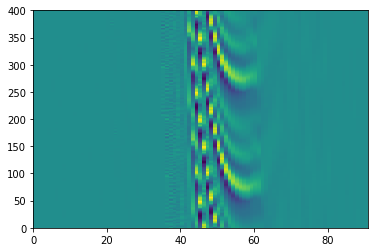

True


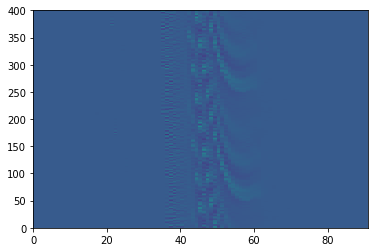

True


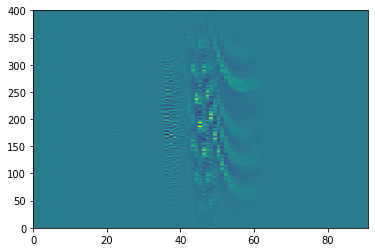

True


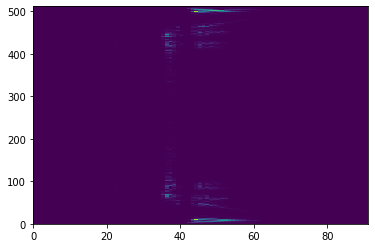

True


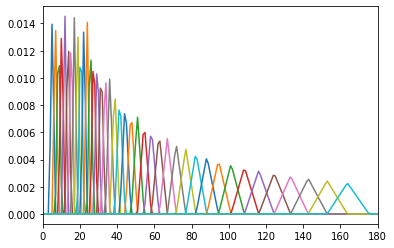

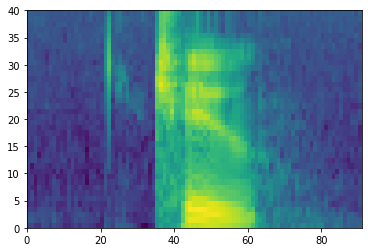

True


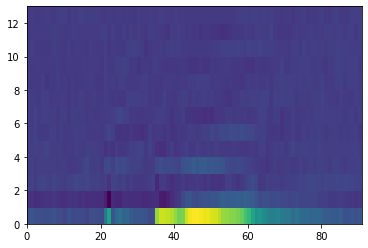

True


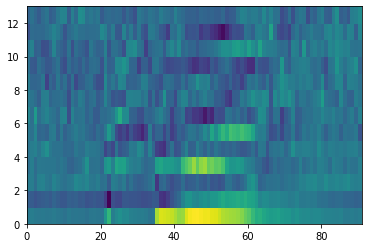

True


In [24]:
#Task 4
import numpy as np
import matplotlib.pyplot as plt

example = np.load('lab1_example.npz', allow_pickle=True)['example'].item()
data = np.load('lab1_data.npz', allow_pickle=True)['data']

sampling_rate = data[0]['samplingrate'] #20000 Hz
# Calculate winlen and winshift
winlen = int(sampling_rate * (20/1000))
winshift = int(sampling_rate * (10/1000))
sampled_frames = enframe(example['samples'] , winlen, winshift, sampling_rate)
plot_colormesh(sampled_frames)
# Assert that enframe is correct
print(np.alltrue(example['frames'] == sampled_frames))

emph_frames = preemp(sampled_frames, p=0.97)
plot_colormesh(emph_frames)
# Assert that preemp is correct
print(np.alltrue(emph_frames == example['preemph']))

win_frames = windowing(emph_frames)
plot_colormesh(win_frames)
# Assert that windowing is correct
print(np.alltrue(win_frames == example['windowed']))

spec = powerSpectrum(win_frames, 512)
plot_colormesh(spec)
# Assert that powerSpectrum is correct
print(np.allclose(spec, example['spec']))

mel_spectrum = logMelSpectrum(spec, sampling_rate, True)
plot_colormesh(mel_spectrum)
# Assert that logMelSpectrum is correct
print(np.allclose(mel_spectrum, example['mspec']))

coff_count = 13
mfcc_coffs = cepstrum(mel_spectrum, coff_count)
plot_colormesh(mfcc_coffs)
# Assert that MFCC coefficients are correct
print(np.allclose(mfcc_coffs, example['mfcc']))

lifter_coff = 22
lmfcc_coffs = lifter(mfcc_coffs, lifter_coff)
plot_colormesh(lmfcc_coffs)
# Assert that LMFCC coefficients are correct
print(np.allclose(lmfcc_coffs, example['lmfcc']))


Corelation coeffecients 

LMFCCs Correlation Coffs - Uncorrelated


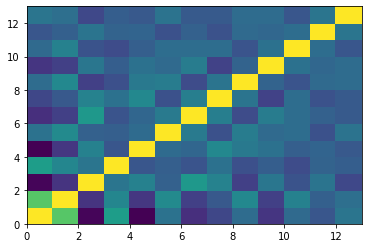

MSPEC(Mel Filterbank) Correlation Coffs - Correlated


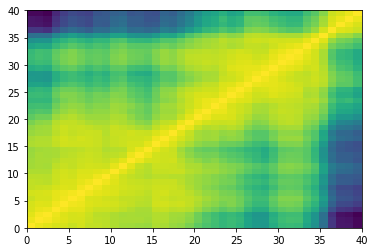

GMM Posteriors for digit 7 

man uttering 7 for the a repetition.:


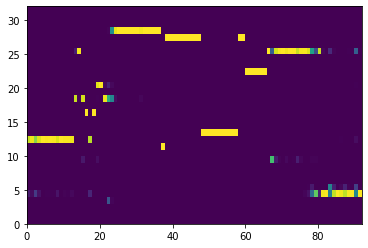

man uttering 7 for the b repetition.:


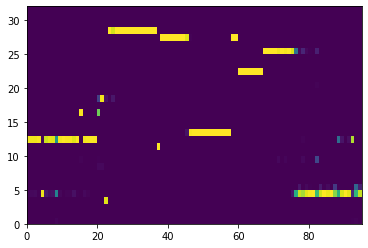

woman uttering 7 for the a repetition.:


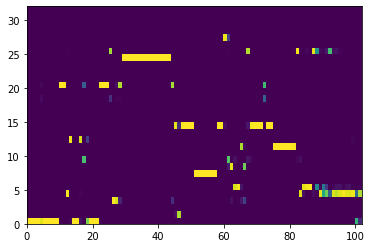

woman uttering 7 for the b repetition.:


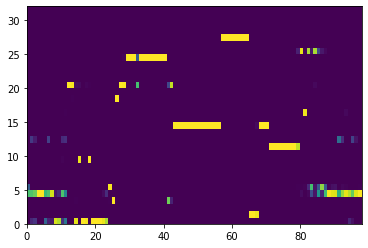

In [25]:
#Task 5 and 6
flag = True
feature_array = None
utterances = []
desired_utterances = []

i = 0
for d in data:
  lmfcc = mfcc(d['samples'], winlen = 400, winshift = 200, preempcoeff=0.97, nfft=512, nceps=13, samplingrate=20000, liftercoeff=22)
  
  # Concatenate LMFCC's
  if(flag):
    feature_array = lmfcc
    flag = False
  else:
    feature_array = np.concatenate((feature_array, lmfcc), axis=0)

  utterances.append(lmfcc)

  # Save utterances desired
  if(i == 16 or i == 17 or i == 38 or i == 39):
    desired_utterances.append((lmfcc, d))

  #plot_lmfcc(i, d, lmfcc)
  i += 1

#Corelation coeffecients
print('Corelation coeffecients \n')
example_mspec = example['mspec']
plot_corelations(feature_array, example_mspec)

# Plot GMM posteriors
components = 32
gmm_posteriors(feature_array, desired_utterances, components)


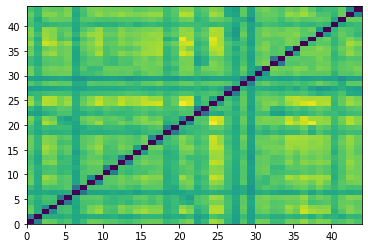

In [31]:
#Task 7

D = []
utt_shape = len(utterances)
euc_dist = lambda x, y : distance.euclidean(x, y)

for i in range(len(utterances)):
  for j in range(len(utterances)):
    #d = dynamic_type_warping(utterances[i], utterances[j], euc_dist) # Using library for DTW
    d = dtw(locd(utterances[i], utterances[j]))
    D.append(d)

D = np.reshape(D, (utt_shape, utt_shape))
plot_colormesh(D)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


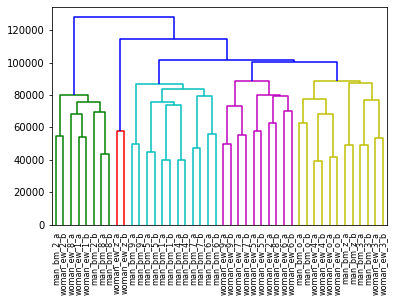

In [0]:
from scipy.cluster.hierarchy import dendrogram, linkage

hierarchical_clustering = linkage(D, 'complete')
labels_dn = tidigit2labels(data)
dendogram_hc = dendrogram(hierarchical_clustering, labels=labels_dn)

In [0]:
#Compare distances within the same digit and across different digits.
#Does the distance separate digits well even between different speakers?
np.set_printoptions(threshold=np.inf)
print(D)

In [0]:
for d in data:
  print("Filename: " + d['filename'] + " Digit: " + d['digit'] + " Gender: " + d['gender'] + " Speaker: " + d['speaker'] + " Rep: " + d['repetition'] + "\n")


Additional Stuff(Not related to the lab work) - 

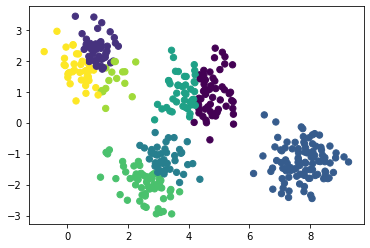

In [0]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

gmm = GaussianMixture(n_components=8).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');